## I. Các thư viện cần thiết

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

# II. Dữ liệu


## 1. Tổng quan

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/UDDLL/Data/Vietnamese Students’ Feedback Corpus (UIT-VSFC)/preprocess/'

In [ ]:
df_train = pd.read_csv(base_dir+'preprocess_synthetic_train.csv')
df_train

,sentence,sentiment,topic
0,Đội_ngũ bảo_trì quá thưa_thớt dẫn đến không đả...,negative,facility
1,Phương_pháp giảng_dạy phù_hợp với các đối_tượn...,neutral,curriculum
2,Chương_trình học giúp tôi trở_thành một chuyên...,positive,curriculum
3,Tôi nghĩ rằng chương_trình đào_tạo có_thể có t...,neutral,curriculum
4,Chị ấy luôn tỉ_mỉ trong công_việc .,neutral,others
...,...,...,...
7824,Hệ_thống an_ninh trong trường rất tốt và đảm_b...,neutral,facility
7825,Cô_giáo đã giúp tôi hiểu rõ hơn về môn_học này .,neutral,others
7826,Anh / chị đã trở_thành một người bạn đồng_hành...,positive,others
7827,Chương_trình học phù_hợp với nhu_cầu của các n...,neutral,curriculum


In [ ]:
df_test = pd.read_csv(base_dir+'preprocess_synthetic_val.csv')
df_test

,sentence,sentiment,topic
0,Chất_lượng vật_chất kém .,negative,facility
1,"Phần_mềm học_tập quá khó sử_dụng , khiến sinh_...",negative,facility
2,Trường tôi thiếu những tiện_ích cơ_bản như máy...,negative,facility
3,Cần tạo thêm các hoạt_động gắn_kết giữa sinh_v...,neutral,curriculum
4,Họ rất khoan_dung và lượng_giác trong quan_điể...,neutral,others
...,...,...,...
1946,Anh ta là một người rất tỉ_mỉ và cẩn_thận .,neutral,others
1947,Giáo_viên đưa ra các phương_tiện hỗ_trợ giảng_...,neutral,curriculum
1948,Thiếu tính linh_hoạt trong hình_thức giảng_dạy...,negative,curriculum
1949,Cô ấy rất sắc_sảo và có khả_năng phân_tích chi...,positive,others


## 2. Trực quan

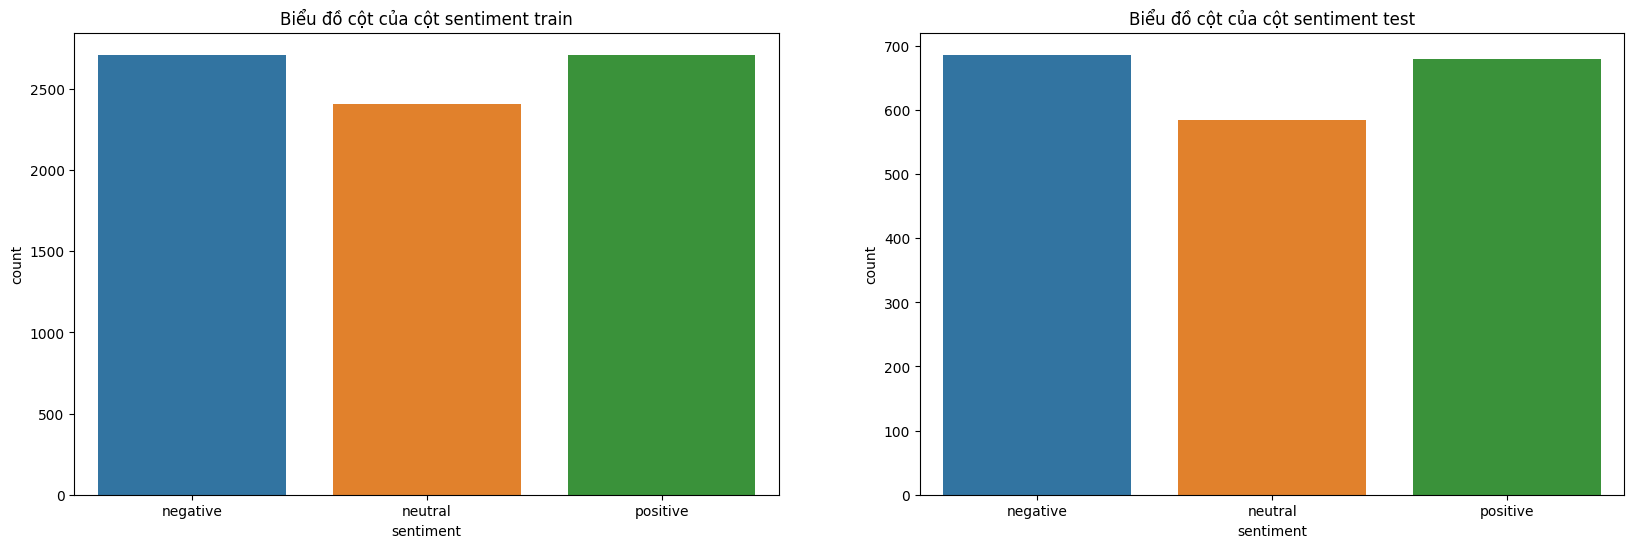

In [ ]:
sentiment_train = df_train['sentiment']
sentiment_test = df_test['sentiment']

# Tạo figure và axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# Vẽ biểu đồ cho tập train
sns.countplot(x=sentiment_train, ax=ax[0])
ax[0].set_title('Biểu đồ cột của cột sentiment train')

# Vẽ biểu đồ cho tập test
sns.countplot(x=sentiment_test, ax=ax[1])
ax[1].set_title('Biểu đồ cột của cột sentiment test')

# Hiển thị biểu đồ
plt.show()

- Dữ liệu được phân chia thành 3 nhãn.
- Số lượng mẫu trong mỗi nhãn khá đồng đều với nhau


## 3. Chia tập dữ liệu

In [ ]:
X_train = df_train.sentence.copy()
X_test = df_test.sentence.copy()

sentiment_train = df_train.sentiment.copy()
sentiment_test = df_test.sentiment.copy()

## 4. Chuyển về one-hot

In [ ]:
# Khởi tạo LabelEncoder
encoder = LabelEncoder()

# Chuyển đổi nhãn dạng chuỗi thành nhãn dạng số
y_train_encoded = encoder.fit_transform(sentiment_train)
y_test_encoded = encoder.transform(sentiment_test)

# Chuyển đổi nhãn dạng số thành dạng one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

print(y_train)
print(encoder.classes_)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
['negative' 'neutral' 'positive']


In [ ]:
y_train.shape

(7829, 3)

# III. Cấu Hình môi trường (chiến lược):

Cấu hình để tận dụng tích hợp TPU (Tensor Processing Unit) hoặc
nhiều GPU (Graphics Processing Unit) trong TensorFlow, nhằm tăng tốc độ huấn luyện mô hình trên
nhiều thiết bị xử lý song song

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

Đoạn mã in ra thông tin về chiến lược phân phối đã
được chọn và số lượng accelerator (đơn vị xử lý, bao gồm cả TPU và GPU) sẽ được sử dụng trong quá
trình huấn luyện.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.52.82.66:8470']
Number of accelerators:  8


# IV. Xây dựng mô hình

In [ ]:
from transformers import TFAutoModel, AutoTokenizer

## 1. Tạo Tokennizer

In [ ]:
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
text = 'Đội ngũ bảo trì quá thưa thớt dẫn đến không đảm bảo được chất lượng sửa chữa thiết bị.'
print(tokenizer(text))
print(tokenizer(text,
                    max_length = 200,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(200))

{'input_ids': [0, 1650, 15679, 1218, 23651, 204, 4532, 17908, 376, 30, 17, 15758, 1218, 11, 567, 525, 2833, 1661, 14945, 22842, 5, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[    0  1650 15679  1218 23651   204  4532 17908   376    30    17 15758
  1218    11   567   525  2833  1661 14945 22842     5     2     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1

- input_ids: Đây là danh sách các ID đại diện cho từng token trong câu đầu vào. Mỗi số trong danh sách tương ứng với một token cụ thể trong từ điển của mô hình.
- token_type_ids: Đây là danh sách dùng để phân biệt các phần khác nhau của đầu vào, thường được sử dụng khi cần xử lý hai câu cùng một lúc (ví dụ: trong tác vụ phân loại câu đôi). Trong trường hợp này, tất cả các giá trị đều là 0, có nghĩa là chỉ có một phần đầu vào (1 câu).
- attention_mask: Đây là danh sách dùng để chỉ ra những token nào là thực sự có ý nghĩa trong câu, và những token nào chỉ là token đệm (padding). Giá trị 1 có nghĩa là token tương ứng cần được mô hình chú ý đến, và giá trị 0 có nghĩa là token đó là token đệm.
-> **Thao này giúp chuẩn hóa và biểu diễn các văn bản dưới dạng số để có thể đưa vào mô hình NLP**

In [ ]:
MAX_LEN = 200
inputs_train = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X_train.items()]

inputs_test = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X_test.items()]

In [ ]:
X_train = np.asarray(inputs_train)
X_test = np.asarray(inputs_test)

In [ ]:
print(X_train)

[[    0 13999  5846 ...     1     1     1]
 [    0  8727  3108 ...     1     1     1]
 [    0  1489   222 ...     1     1     1]
 ...
 [    0   157    95 ...     1     1     1]
 [    0  1489   222 ...     1     1     1]
 [    0   218   115 ...     1     1     1]]


In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

- Mô hình PhoBert có 2 đầu ra:
  - Thể hiện ở dòng `PhoBert(input_ids)[1]`
  - Output thứ nhất: Đây là ma trận biểu diễn (embedding) cho mỗi token trong câu đầu vào
  - Output thứ hai: Đây là vector biểu diễn cho token `[CLS]` trong câu đầu vào. Token `[CLS]` thường được thêm vào đầu câu đầu vào và được sử dụng như một dạng biểu diễn toàn cục (global representation) của cả câu.
-> Cả hai output này đều chứa thông tin quan trọng và được sử dụng trong các tác vụ khác nhau. **Ví dụ, output thứ nhất** thường được sử dụng trong các tác vụ gán nhãn cho từng token (như gán nhãn từ loại, nhận dạng thực thể có tên,…), **trong khi output thứ hai** thường được sử dụng trong các tác vụ phân loại câu hoặc câu đôi (như phân loại cảm xúc, hiểu ngữ cảnh,…).

## 2. Khởi tạo mô hình

In [ ]:
# Build model
with strategy.scope():
    PhoBert = TFAutoModel.from_pretrained(model_name) # Tải lên mô hình PhoBert

    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32) # Tạo một đối tượng Input trong TensorFlow

    embedding = PhoBert(input_ids)[1] # Truyền đầu vào input_ids vào mô hình PhoBert và lấy ra embedding tương ứng

    #  Tạo một lớp Dense với 128 nút, hàm kích hoạt ReLU, và sử dụng điều chuẩn L2 với hệ số 0.1. Lớp này nhận đầu vào là embedding
    x = Dense(128, activation = 'relu', kernel_regularizer = regularizers.L2(0.1))(embedding)
    # Tạo một lớp Dropout với tỷ lệ dropout là 0.2. Lớp này nhận đầu vào là output của lớp Dense trước đó.
    x = Dropout(0.2)(x)
    # Dòng này tạo một lớp Dense khác, với số lượng nút bằng với số lượng lớp trong encoder.classes_ (trong trường hợp này là 3)
    x = Dense(len(encoder.classes_),
              activation = 'softmax',
              kernel_initializer=tf.initializers.GlorotUniform(seed=1905),
              name='output_layer')(x)

    # Tạo một đối tượng Model trong TensorFlow, với đầu vào là input_ids và đầu ra là x.
    model = Model(inputs=[input_ids], outputs = x)

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Hàm sofmax sẽ cho ra kết quả từ 0-1

Nguyên lý đằng sau hàm Softmax khá đơn giản. Với một vài số cho trước

- Tính hàm lũy thừa số e, với số mũ là những số đã cho
- Tính tổng các lũy thừa đó. Đó sẽ là mẫu số.
- Sử dụng lũy thừa của mỗi số là tử số
- Xác suất sẽ là tử số/mẫu số


Viết ngắn gọn lại, ta được công thức hàm Softmax:
 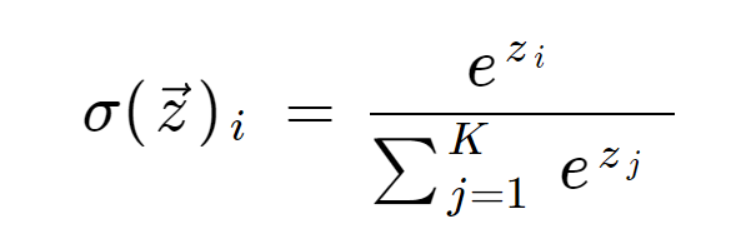

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf_roberta_model (TFRoberta  TFBaseModelOutputWithPoo  134998272
 Model)                      lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

## 3. Cấu hình siêu tham số

Xác định lịch learning rate và trọng số weight decay với optimizer là Adam sử dụng thư viện TensorFlow Addons. Biên dịch mô hình với các siêu tham số tùy chỉnh như sau:

In [ ]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-3, 1e-4, 1e-5])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

- `step = tf.Variable(0, trainable=False)`: Tạo ra một biến TensorFlow step với giá trị khởi tạo là 0. Tham số trainable=False chỉ ra rằng biến này không được cập nhật trong quá trình huấn luyện thông qua lan truyền ngược (backpropagation).

- `schedule = tf.optimizers.schedules.PiecewiseConstantDecay([10000, 15000], [1e-3, 1e-4, 1e-5])`: Tạo ra một đối tượng PiecewiseConstantDecay, một loại lịch trình học phổ biến trong TensorFlow. Lịch trình này sẽ giảm tỷ lệ học (learning rate) theo các bước nhảy cố định. Trong trường hợp này, tỷ lệ học sẽ là 1e-3 cho đến bước thứ 10000, sau đó giảm xuống 1e-4 cho đến bước thứ 15000, và cuối cùng giảm xuống 1e-5 cho tất cả các bước sau đó.

- `lr = 1e-2 * schedule(step)`: Tạo ra tỷ lệ học thực tế lr bằng cách nhân tỷ lệ học từ lịch trình với 1e-2. Tỷ lệ học này sẽ được cập nhật sau mỗi bước huấn luyện dựa trên giá trị của step.

- `wd = lambda: 1e-5 * schedule(step)`: Để tính toán trọng số điều chuẩn (weight decay) wd. Trọng số điều chuẩn này cũng sẽ được cập nhật sau mỗi bước huấn luyện dựa trên giá trị của step.

In [ ]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])


Hàm mất mát (trong trường hợp này là CategoricalCrossentropy) đo lường sự khác biệt giữa dự đoán của mô hình và giá trị thực tế. Nó không chỉ quan tâm đến việc mô hình có dự đoán đúng lớp hay không, mà còn quan tâm đến mức độ “chắc chắn” của mô hình trong việc dự đoán đó. Ví dụ, nếu mô hình dự đoán một mẫu thuộc về lớp A với xác suất 51% và lớp B với xác suất 49%, mặc dù dự đoán có thể được coi là đúng nếu mẫu thực sự thuộc về lớp A, nhưng vì mô hình không tự tin vào dự đoán của mình, hàm mất mát sẽ cao.

In [ ]:
# Train model
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    verbose = 1,
                    validation_split = 0.1,
                    batch_size = 128)

Epoch 1/20
56/56 [==============================] - 271s 1s/step - loss: 22.7675 - accuracy: 0.3733 - val_loss: 22.5007 - val_accuracy: 0.4738
Epoch 2/20
56/56 [==============================] - 12s 217ms/step - loss: 22.0277 - accuracy: 0.6206 - val_loss: 21.5628 - val_accuracy: 0.7356
Epoch 3/20
56/56 [==============================] - 12s 215ms/step - loss: 21.2859 - accuracy: 0.7759 - val_loss: 21.0400 - val_accuracy: 0.7880
Epoch 4/20
56/56 [==============================] - 12s 217ms/step - loss: 20.8240 - accuracy: 0.7958 - val_loss: 20.6016 - val_accuracy: 0.8008
Epoch 5/20
56/56 [==============================] - 12s 217ms/step - loss: 20.3751 - accuracy: 0.8202 - val_loss: 20.1686 - val_accuracy: 0.8084
Epoch 6/20
56/56 [==============================] - 12s 216ms/step - loss: 19.9429 - accuracy: 0.8358 - val_loss: 19.7575 - val_accuracy: 0.8327
Epoch 7/20
56/56 [==============================] - 12s 215ms/step - loss: 19.5233 - accuracy: 0.8479 - val_loss: 19.3604 - val_accu

## 4. Đánh giá mô hình

Trực quan lần lượt accuray và loss của mô hình:

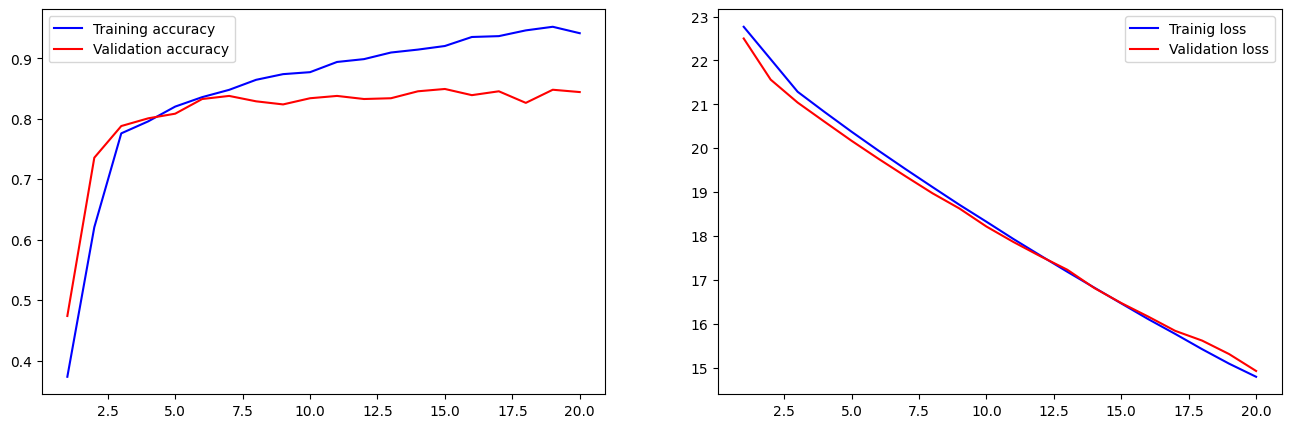

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()

- Như ta thấy, mô hình sau khi huấn luyện qua nhiều epoch đã có thể tối thiểu hóa hàm loss và tăng accuracy trên cả tập train và val.



## 5. Kiểm thử trên tập test (chưa được làm giàu)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 11s 777ms/step - loss: 14.8184 - accuracy: 0.8795
test loss, test acc: [14.818371772766113, 0.879548966884613]


Accucary cuối cùng đạt được xấp xỉ 0.85. Chứng tỏ mô hình đã hoạt
động tốt trên tập dữ liệu

## Lưu model

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
dir_model = '/content/drive/MyDrive/Colab Notebooks/UDDLL/Model'
# Lưu kiến trúc của mô hình dưới dạng JSON
model_json = model.to_json()
with open(dir_model+"/model.json", "w") as json_file:
    json_file.write(model_json)

# Lưu trọng số của mô hình
model.save_weights(dir_model+"/model_weights.h5")

# test load

In [ ]:
from transformers import TFRobertaModel
from tensorflow.keras.models import model_from_json

dir_model = '/content/drive/MyDrive/Colab Notebooks/UDDLL/Model'
# Mở tệp JSON và đọc kiến trúc
with open(dir_model+'/model.json', 'r') as json_file:
    model_json = json_file.read()

# Tải mô hình từ JSON
model = model_from_json(model_json, custom_objects={'TFRobertaModel': TFRobertaModel})

# Tải trọng số vào mô hình
model.load_weights(dir_model+"/model_weights.h5")


In [ ]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
8/8 [==============================] - 94s 11s/step - loss: 14.8182 - accuracy: 0.8806
test loss, test acc: [14.818207740783691, 0.8805740475654602]
